In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader.data as web
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from sklearn.impute import SimpleImputer
from tpot.export_utils import set_param_recursive
from tpot.builtins import ZeroCount
from sklearn.tree import DecisionTreeClassifier

In [ ]:
random_state = 42

## 1. Data Prepare

use S&P 500 index from 2010-01-01 to 2020-01-01 to be whole dataset.

In [ ]:
SPX = web.DataReader(name='^GSPC',data_source='yahoo',start='2010-01-01',end='2020-01-01')

In [ ]:
SPX.head()

## 2. Feature Engineering

In [48]:
def NR(data,k):
    ''' NRk
    range R[i] = High[i] - Low[i]
    NRk exists if today's range is less than the ranges for the previous k-1 days:
    R[0] < min(R[1], R[2], ... , R[k-1])
    NRk days represent volatility contraction.
    The greater the number of narrow range days, the greater the counter reaction in wide ranging days.
    '''
    data['R'] = data['High'] - data['Low']
    for i in range(k,len(data)):
        R = []
        for j in range(i-k,i):
            R.append(data.ix[j,'R'])
        R.append(data.ix[i,'R'])
        data.ix[i,'NR'] = sorted(R,reverse = True).index(data.ix[i,'R'])
    return data

In [28]:
def DOJI(data,rho):
    ''' DOJI
    DOJI indicates that the open and close for the trading day are within some small percentage(x) of each other.
    A DOJI means the market reflects temporary price indecision and often signals a reversal.
    define:
        DOJI(x) = 1, when |O - C| <= x * (H - L); 0, otherwise
    where rho in [0.05,0.3)
    '''
    temp = data.copy()
    temp['x'] = (temp['Open'] - temp['Adj Close']) / temp['Adj Close']
    temp['DOJI_new'] = np.nan
    temp['DOJI_new'][(temp.x>=0) & (temp.x<=rho)] = 1 - temp.x/rho
    temp['DOJI_new'][temp['DOJI_new'].isnull()] = 0
    return temp['DOJI_new']

In [29]:
def Hookday(data,delta = 0.5,kind = 'up'):
    ''' Hookday
    A hook day occurs when the price opens outside the previous day's range and then proceeds to reverse direction,
    generally indicating a reaction to temporarily overbought or oversold market condition.
    Up hook day:
        O[-1] < L[0] - delta
    Down hook day:
        O[-1] > H[0] + delta
    where delta is between [0,10]
    '''
    temp = data.copy()
    if kind=='up':
        temp['x'] = temp.Low - delta - temp.Open.shift(-1)
    elif kind=='down':
        temp['x'] = temp.Open.shift(-1) - temp.High - delta 
    temp['Hookday'] = np.nan
    temp['Hookday'][temp.x<-0.5] = 0
    temp['Hookday'][(temp.x>=-0.5) & (temp.x<0)] = 2 * (temp.x + 0.5)
    temp['Hookday'][temp.x>=0] = 1
    return temp['Hookday']

## 3. Fuzzy Membership Functions

Fuzzy membership functions transform a 'yes' or 'no' question into fuzzy answers somewhere between a 'yes' or 'no'.
map days(D) onto the unit interval via a function $\mu(D)$.
It returns a value between 0 and 1 indicating to what degree features are present. Then, the fuzzy output variable is defuzzied to produce a crisp value on the unit interval, which the desirability of buying stock on the next trading day.

For NRk:

$$
\mu_{k}(x)=\begin{cases}
    0,&x<v_{min} \\ c(x-v_{min}),&x \in [v_{min},v_{max}) \cr 1,&x>=v_{max}
\end{cases}
$$

Parameter values:

| $k$ | $c$   | $v_{min}$ | $v_{max}$ |
| :--:| :----:| :----:    | :--------:|
| 4   | 1/2   | 2         | 4         |
| 6   | 1/3   | 3         | 6         |
| 7   | 1/3   | 4         | 7         |

In [30]:
def memfun_NR(data,k,c,vmin,vmax):
    temp = data.copy()
    temp['R_tilda'] = temp['R'].rolling(window=k).max()
    temp['x'] = temp['NR'] + (1 - temp.R/temp['R_tilda']) 
    temp['NR_new'] = np.nan
    temp['NR_new'][temp.x<vmin] = 0
    temp['NR_new'][(temp.x>=vmin) & (temp.x<vmax)] = c * (temp.x - vmin)
    temp['NR_new'][temp.x>=vmax] = 1
    return temp['NR_new']

For DOJI:

$$
\mu(x)=\begin{cases}
    1 - \frac{x}{p}, &x \in[0,p]  \cr 0,&x \in otherwise
\end{cases}
$$

For Hookday:

$$
\mu(x)=\begin{cases}
    0,&x<1/2 \\ 2(x+0.5),&x \in [-1/2,0) \cr 1,&x>=0
\end{cases}
$$

Fuzzy membership function is inside the function of DOJI and Hookday.

## 4. Evolutionary Algorithm

![title](theory.png)

![title](theory2.png)

In [62]:
inputdata = SPX.copy()
inputdata['NR4'] = memfun_NR(NR(inputdata,4),4,0.5,2,4)
inputdata['NR6'] = memfun_NR(NR(inputdata,6),6,1/3,3,6)
inputdata['NR7'] = memfun_NR(NR(inputdata,7),7,1/3,4,7)

inputdata['DOJI'] = DOJI(inputdata,0.1)

inputdata['Hookday'] = Hookday(inputdata)

In [63]:
inputdata.head()

,High,Low,Open,Close,Volume,Adj Close,R,NR,NR4,NR6,NR7,DOJI,Hookday
Date,,,,,,,,,,,,,
2010-01-04,1133.869995,1116.560059,1116.560059,1132.989990,3991400000,1132.989990,17.309937,NaN,NaN,NaN,NaN,0.0,0.0
2010-01-05,1136.630005,1129.660034,1132.660034,1136.520020,2491020000,1136.520020,6.969971,NaN,NaN,NaN,NaN,0.0,0.0
2010-01-06,1139.189941,1133.949951,1135.709961,1137.140015,4972660000,1137.140015,5.239990,NaN,NaN,NaN,NaN,0.0,0.0
2010-01-07,1142.459961,1131.319946,1136.270020,1141.689941,5270680000,1141.689941,11.140015,NaN,NaN,NaN,NaN,0.0,0.0
2010-01-08,1145.390015,1136.219971,1140.520020,1144.979980,4389590000,1144.979980,9.170044,2.0,0.088419,NaN,NaN,0.0,0.0


In [64]:
inputdata.describe()

,High,Low,Open,Close,Volume,Adj Close,R,NR,NR4,NR6,NR7,DOJI,Hookday
count,2517.000000,2517.000000,2517.000000,2517.000000,2.517000e+03,2517.000000,2517.000000,2513.000000,2513.000000,2512.000000,2511.000000,2517.000000,2516.000000
mean,1971.857815,1952.710315,1962.657448,1963.123451,3.715144e+09,1963.123451,19.147500,3.523279,0.379875,0.359534,0.325428,0.429338,0.060922
std,590.630866,588.063705,589.469001,589.358946,8.132577e+08,589.358946,13.278299,2.346471,0.417266,0.405246,0.400751,0.470262,0.236023
min,1032.949951,1010.909973,1027.650024,1022.580017,1.025000e+09,1022.580017,3.680054,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1390.780029,1373.030029,1382.180054,1385.140015,3.237960e+09,1385.140015,10.799927,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1993.479980,1975.670044,1985.319946,1986.510010,3.587860e+09,1986.510010,15.510010,3.000000,0.144839,0.122601,0.000000,0.000000,0.000000
75%,2441.620117,2428.020020,2434.270020,2434.500000,4.076170e+09,2434.500000,23.190063,6.000000,0.779185,0.827771,0.815504,0.958493,0.000000
max,3258.139893,3235.530029,3247.229980,3257.850098,1.061781e+10,3257.850098,125.219971,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [65]:
inputdata['returns'] = np.log(inputdata['Adj Close'].shift(-1)) - np.log(inputdata['Adj Close'])

# select days in which we have positive returns in order to find up-trend days
inputdata['target'] = inputdata['returns'].apply(lambda x: 1 if x>0 else 0)

In [66]:
train = inputdata[['NR4','NR6','NR7','DOJI','Hookday','target']][inputdata.index<'2016']
test = inputdata[['NR4','NR6','NR7','DOJI','Hookday','target']][inputdata.index>='2016']

train = train.dropna()
test = test.dropna()

X_train = train.drop(columns=['target'])
y_train = train['target']

X_test = test.drop(columns=['target'])
y_test = test['target']

In [67]:
# initialize  evolutionary strategy
tpot = TPOTClassifier(generations=100, population_size=50,
                         offspring_size=None, mutation_rate=0.9,
                         crossover_rate=0.1,
                         scoring='accuracy', cv=5,
                         subsample=1, n_jobs=1,
                         max_time_mins=10, max_eval_time_mins=0.04,
                         random_state=random_state, config_dict=None,
                         warm_start=False,
                         memory=None,
                         use_dask=False,
                         periodic_checkpoint_folder=None,
                         early_stop=500,
                         verbosity=2,
                         disable_update_check=True)

In [68]:
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))
tpot.export('tpot_digits_pipeline.py')

Generation 1 - Current best internal CV score: 0.56384496124031
Generation 2 - Current best internal CV score: 0.56384496124031
Generation 3 - Current best internal CV score: 0.5645116279069767
Generation 4 - Current best internal CV score: 0.5645116279069767
Generation 5 - Current best internal CV score: 0.5645116279069767
Generation 6 - Current best internal CV score: 0.5645116279069767
Generation 7 - Current best internal CV score: 0.5665094130675526
Generation 8 - Current best internal CV score: 0.5678449612403101
Generation 9 - Current best internal CV score: 0.5678449612403101
Generation 10 - Current best internal CV score: 0.5718316722037653
Generation 11 - Current best internal CV score: 0.5724961240310078
Generation 12 - Current best internal CV score: 0.5724961240310078
Generation 13 - Current best internal CV score: 0.5724961240310078
Generation 14 - Current best internal CV score: 0.5724961240310078
Generation 15 - Current best internal CV score: 0.5724961240310078
Generati

TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=5,
               disable_update_check=True, early_stop=500, generations=100,
               max_eval_time_mins=0.04, max_time_mins=10, memory=None,
               mutation_rate=0.9, n_jobs=1, offspring_size=None,
               periodic_checkpoint_folder=None, population_size=50,
               random_state=42, scoring='accuracy', subsample=1, template=None,
               use_dask=False, verbosity=2, warm_start=False)

0.5815109343936382


I set the maximum time, so indeed it only passes through 44 generations rather than 100 as I set.

In [87]:
# NOTE: Make sure that the outcome column is labeled 'target' in the data file
# tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
# features = tpot_data.drop('target', axis=1)
# training_features, testing_features, training_target, testing_target = \
#             train_test_split(features, tpot_data['target'], random_state=42)

imputer = SimpleImputer(strategy="median")
_ = imputer.fit(X_train)
training_features = imputer.transform(X_train)
testing_features = imputer.transform(X_test)

# Average CV score on the training set was: 0.5744872646733112
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=GaussianNB()),
    KNeighborsClassifier(n_neighbors=76, p=1, weights="uniform")
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', random_state)

model = exported_pipeline.fit(X_train, y_train)
results = exported_pipeline.predict(X_test)

In [88]:
temp = X_test.copy()
temp['pred'] = results

temp['returns'] = inputdata['returns']

In [89]:
temp.head()

,NR4,NR6,NR7,DOJI,Hookday,pred,returns
Date,,,,,,,
2016-01-04,0.000000,0.000000,0.000000,0.873104,0.0,1,0.002010
2016-01-05,0.816880,0.211254,0.211254,0.000000,0.0,1,-0.013202
2016-01-06,0.000000,0.000000,0.000000,0.892225,0.0,1,-0.023986
2016-01-07,0.000000,0.000000,0.000000,0.782666,0.0,1,-0.010898
2016-01-08,0.048934,0.000000,0.000000,0.875444,0.0,1,0.000853


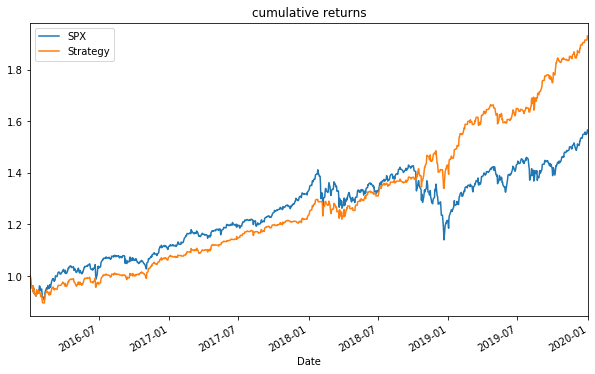

In [90]:
SPX['returns'] = np.log(SPX['Adj Close'].shift(-1)) - np.log(SPX['Adj Close'])
_ = (1+ SPX['returns'][SPX.index>='2016']).cumprod().plot(title = 'cumulative returns',figsize=(10,6),label = 'SPX')
_ = ((1 + temp.returns * temp.pred).cumprod()).plot(label = 'Strategy')
_ = plt.legend()


## 5. Optimization

In [95]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(tpot.fit(X_train, y_train), n_jobs=-1,param_grid={'generations':[20,50,100], 
                        'population_size':[15,25,50],
                         'max_time_mins':[10,100]},cv = 6,scoring='accuracy',verbose=0)
grid_search.fit(X_train,y_train)
print("grid_search.best_estimator_:",grid_search.best_estimator_)
# print("grid_search.cv_results_:",grid_search.cv_results_)
print("grid_search.best_score_:",grid_search.best_score_)
best_model = grid_search.best_estimator_


Generation 1 - Current best internal CV score: 0.56384496124031
Generation 2 - Current best internal CV score: 0.56384496124031
Generation 3 - Current best internal CV score: 0.5645116279069767
Generation 4 - Current best internal CV score: 0.5645116279069767
Generation 5 - Current best internal CV score: 0.5645116279069767
Generation 6 - Current best internal CV score: 0.5645116279069767
Generation 7 - Current best internal CV score: 0.5665094130675526
Generation 8 - Current best internal CV score: 0.5678449612403101
Generation 9 - Current best internal CV score: 0.5678449612403101
Generation 10 - Current best internal CV score: 0.5718316722037653
Generation 11 - Current best internal CV score: 0.5724961240310078
Generation 12 - Current best internal CV score: 0.5724961240310078
Generation 13 - Current best internal CV score: 0.5724961240310078
Generation 14 - Current best internal CV score: 0.5724961240310078
Generation 15 - Current best internal CV score: 0.5724961240310078
Generati

Generation 1 - Current best internal CV score: 0.5611849390919159
Generation 2 - Current best internal CV score: 0.5625182724252491
Generation 3 - Current best internal CV score: 0.5625182724252491
Generation 4 - Current best internal CV score: 0.56318715393134
Generation 5 - Current best internal CV score: 0.5645116279069767
Generation 6 - Current best internal CV score: 0.5645116279069767
Generation 7 - Current best internal CV score: 0.5645116279069767
Generation 8 - Current best internal CV score: 0.5678449612403101
Generation 9 - Current best internal CV score: 0.5705027685492802
Generation 10 - Current best internal CV score: 0.5705027685492802
Generation 11 - Current best internal CV score: 0.5705027685492802
Generation 12 - Current best internal CV score: 0.5711672203765227
Generation 13 - Current best internal CV score: 0.5711672203765227
Generation 14 - Current best internal CV score: 0.5718316722037653
Generation 15 - Current best internal CV score: 0.5718316722037653
Genera

GridSearchCV(cv=6, error_score=nan,
             estimator=TPOTClassifier(config_dict=None, crossover_rate=0.1,
                                      cv=5, disable_update_check=True,
                                      early_stop=500, generations=100,
                                      max_eval_time_mins=0.04, max_time_mins=10,
                                      memory=None, mutation_rate=0.9, n_jobs=1,
                                      offspring_size=None,
                                      periodic_checkpoint_folder=None,
                                      population_size=50, random_state=42,
                                      scoring='accuracy', subsample=1,
                                      template=None, use_dask=False,
                                      verbosity=2, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'generations': [20, 50, 100],
                         'max_time_mins': [10, 100],
                    

grid_search.best_estimator_: TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=5,
               disable_update_check=True, early_stop=500, generations=50,
               max_eval_time_mins=0.04, max_time_mins=10, memory=None,
               mutation_rate=0.9, n_jobs=1, offspring_size=None,
               periodic_checkpoint_folder=None, population_size=25,
               random_state=42, scoring='accuracy', subsample=1, template=None,
               use_dask=False, verbosity=2, warm_start=False)
grid_search.best_score_: 0.5618300132802125


use grid search to find out the best parameter values of number of generation, number of population size, and max time to run. This code takes several hours to finish.

The result shows that the best one is:

grid_search.best_estimator_: TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=5,
               disable_update_check=True, early_stop=500, generations=50,
               max_eval_time_mins=0.04, max_time_mins=10, memory=None,
               mutation_rate=0.9, n_jobs=1, offspring_size=None,
               periodic_checkpoint_folder=None, population_size=25,
               random_state=42, scoring='accuracy', subsample=1, template=None,
               use_dask=False, verbosity=2, warm_start=False)
grid_search.best_score_: 0.5618300132802125

In [96]:
best_pred = grid_search.predict(X_test)

In [97]:
temp2 = X_test.copy()
temp2['pred'] = best_pred

temp2['returns'] = inputdata['returns']

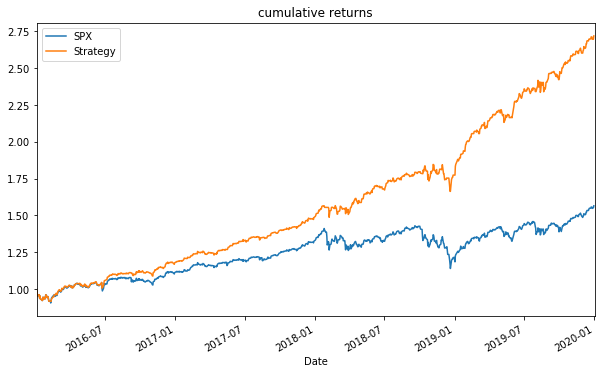

In [98]:
_ = (1+ SPX['returns'][SPX.index>='2016']).cumprod().plot(title = 'cumulative returns',figsize=(10,6),label = 'SPX')
_ = ((1 + temp2.returns * temp2.pred).cumprod()).plot(label = 'Strategy')
_ = plt.legend()

## 6. Find down-trending days

In [104]:
inputdata2 = SPX.copy()
inputdata2['NR4'] = memfun_NR(NR(inputdata2,4),4,0.5,2,4)
inputdata2['NR6'] = memfun_NR(NR(inputdata2,6),6,1/3,3,6)
inputdata2['NR7'] = memfun_NR(NR(inputdata2,7),7,1/3,4,7)

inputdata2['DOJI'] = DOJI(inputdata,0.1)

inputdata2['Hookday'] = Hookday(inputdata2,kind = 'down')

In [105]:
inputdata2['returns'] = np.log(inputdata2['Adj Close'].shift(-1)) - np.log(inputdata2['Adj Close'])

# select days in which we have negative returns in order to find down-trend days
inputdata2['target'] = inputdata2['returns'].apply(lambda x: 1 if x<0 else 0)

In [106]:
train2 = inputdata2[['NR4','NR6','NR7','DOJI','Hookday','target']][inputdata2.index<'2016']
test2 = inputdata2[['NR4','NR6','NR7','DOJI','Hookday','target']][inputdata2.index>='2016']

train2 = train2.dropna()
test2 = test2.dropna()

X_train2 = train2.drop(columns=['target'])
y_train2 = train2['target']

X_test2 = test2.drop(columns=['target'])
y_test2 = test2['target']

In [107]:
# use the best parameters before
tpot2 = TPOTClassifier(generations=50, population_size=25,
                         offspring_size=None, mutation_rate=0.9,
                         crossover_rate=0.1,
                         scoring='accuracy', cv=5,
                         subsample=1, n_jobs=1,
                         max_time_mins=10, max_eval_time_mins=0.04,
                         random_state=random_state, config_dict=None,
                         warm_start=False,
                         memory=None,
                         use_dask=False,
                         periodic_checkpoint_folder=None,
                         early_stop=500,
                         verbosity=2,
                         disable_update_check=True)

In [108]:
tpot2.fit(X_train2, y_train2)
print(tpot2.score(X_test2, y_test2))
tpot2.export('tpot_digits_pipeline_down.py')

Generation 1 - Current best internal CV score: 0.5479025470653378
Generation 2 - Current best internal CV score: 0.5578648947951275
Generation 3 - Current best internal CV score: 0.5578648947951275
Generation 4 - Current best internal CV score: 0.5578648947951275
Generation 5 - Current best internal CV score: 0.5578648947951275
Generation 6 - Current best internal CV score: 0.5578648947951275
Generation 7 - Current best internal CV score: 0.5578671096345514
Generation 8 - Current best internal CV score: 0.5578671096345514
Generation 9 - Current best internal CV score: 0.5578671096345514
Generation 10 - Current best internal CV score: 0.5585359911406422
Generation 11 - Current best internal CV score: 0.5598582502768549
Generation 12 - Current best internal CV score: 0.5598582502768549
Generation 13 - Current best internal CV score: 0.5598582502768549
Generation 14 - Current best internal CV score: 0.5598582502768549
Generation 15 - Current best internal CV score: 0.5618538205980066
Gene

TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=5,
               disable_update_check=True, early_stop=500, generations=50,
               max_eval_time_mins=0.04, max_time_mins=10, memory=None,
               mutation_rate=0.9, n_jobs=1, offspring_size=None,
               periodic_checkpoint_folder=None, population_size=25,
               random_state=42, scoring='accuracy', subsample=1, template=None,
               use_dask=False, verbosity=2, warm_start=False)

0.5636182902584493


In [113]:
# Average CV score on the training set was: 0.5704872646733112
exported_pipeline2 = make_pipeline(
    ZeroCount(),
    DecisionTreeClassifier(criterion="gini", max_depth=8, min_samples_leaf=5, min_samples_split=16)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline2.steps, 'random_state', random_state)

exported_pipeline2.fit(X_train2, y_train2)
results2 = exported_pipeline2.predict(X_test2)

Pipeline(memory=None,
         steps=[('zerocount', ZeroCount()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=8,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=5,
                                        min_samples_split=16,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=42,
                                        splitter='best'))],
         verbose=False)

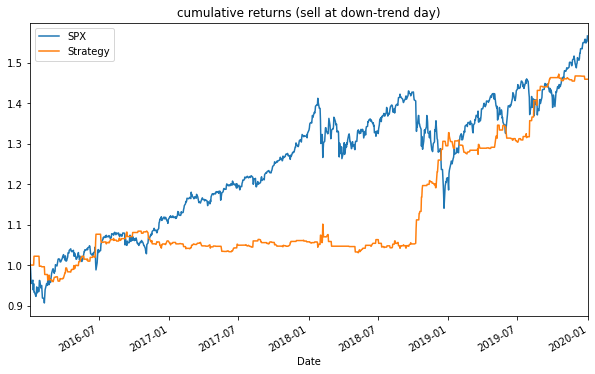

In [142]:
temp2 = X_test2.copy()
temp2['pred_down'] = results2

temp2['returns'] = inputdata2['returns']

_ = (1+ SPX['returns'][SPX.index>='2016']).cumprod().plot(title = 'cumulative returns (sell at down-trend day)',\
                                                          figsize=(10,6),label = 'SPX')
_ = ((1 - temp2.returns * temp2.pred_down).cumprod()).plot(label = 'Strategy')
_ = plt.legend()

We can see that although the cumulative return is lower than S&P 500 index, but the strategy makes profit when the market is going down. That means it figures out the down-trend signal to some aspect.

## 7. Combine two strategies

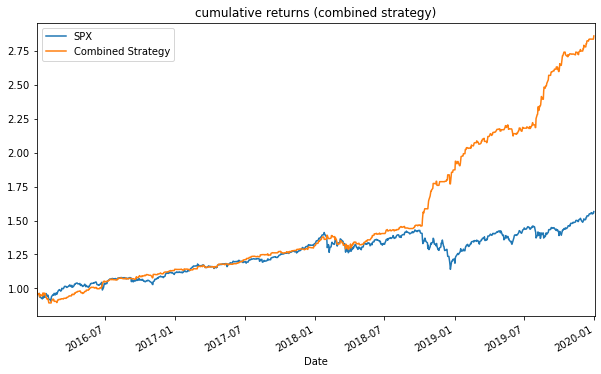

In [152]:
combine = pd.concat([temp[['pred','returns']],temp2['pred_down']],axis = 1)

def new_pred(a,b):
    if a == 0 and b == 1:
        return -1
    elif a == 1 and b == 1:
        return 0
    elif a ==0 and b == 0:
        return 0
    elif a == 1 and b == 0:
        return 1

combine['new_pred'] = combine.apply(lambda x:new_pred(x.pred,x.pred_down),axis = 1)

_ = (1+ SPX['returns'][SPX.index>='2016']).cumprod().plot(title = 'cumulative returns (combined strategy)',\
                                                          figsize=(10,6),label = 'SPX')
_ = ((1 + combine.returns * combine.new_pred).cumprod()).plot(label = 'Combined Strategy')
_ = plt.legend()

In [151]:
print('Done !')

Done !
